## Why YOLO ?

We have talked about the RCNN architecture in previous notebook "Advance CNN", where we use region proposal for detection of object and then go ahead with creating bounding boxes. And generation of these region proposals consumes time and reduces the speed to detect the object in real time.

Yolo is a real time object detection algorithm. It proritize the speed and recognition of object, than going with region proposals tasks. The region based methods uses the windows sliding approach to find regions of object. YOLO makes use of an approach called GRID. 


## Assigning Vector To GRID Cells:

To detect the object, it considers the image as grid of cells of some finer size. Each cell outputs a vector of size 8, which includes [P_c, C1, C2,.., Cn, x, y, w, h], the total number of classes vary. For instance, we are looking for 3 objects in an image, then we have 3 classes. So the associated vector of each of the cell would be [P_c, C1, C2, C3, x, y, w, h]. P_c refers to the probability that if any of the object in the cell is present in that cell i.e. 0 or 1 (a threshold is set, to whether to either reject or accept the cell for analysis). Based on P_c, we can either accept or reject the cell for further analysis. Now, C1,C2,C3 are the class probability of an object in an image, which turns 1/0 based on the classification of the cell. And since each are cells, we have width and height of the cells and it helps in building the Bounding Boxes.

If an object of interest is found in a cell, then automatically adjacent cells tend to have P_c value better than majority of the cells far from the cell where object is present.

To train a model for YOLO, the input image is taken as first the grid size if image is broken into 5x10 cells in a  grid, with each cell outputting 8 depth vector, i.e. 5x10x8.


## Generate Bounding Boxes for training images

While training a YOLO network, the images in the training set needs to be in specific standard for the model to consume. To manually label the training images:

   **First the center point of the object in the image is taken, which is present in one cell among 5x10 cells.**
   
   **The x and y value is calculated for the center point with respect to cell.**
   
   **Each cell starts with (0,0) from top left and width & height of the cell is calculated with respect to the image.**
   
   **Sometimes the Width and Height value would be larger than the x and y.**

## Non Maximal Suppression

Yolo generates lot of bounding boxes for the same object in an image and each box vary slightly from other boxes. It uses Non Maximal Suppression technique to find a bounding box which will accurately identify the object.

### Intersection Over Union (IOU)

Consider there are two bounding boxes over an object, the ratio of intersection of the bounding these two boxes to union of these two boxes gives us IOU value. Now, consider the ground truth value of the bounding box versus the predicted bounding box, if the IOU value of these two boxes are greater then the predicted bounding box value is similar to ground truth box.

### Notes

#### IoU Values

The IoU between two bounding boxes will always have a value between 0 and 1 because, as two boxes drift apart, their intersection approaches 0, but if two bounding boxes overlap perfectly, then its IoU will be 1.
So, higher value of the bounding box means that object is detected by the bounding box accurately.

And also the predicted bounding box vector has P_c value, which gives the probability of the detected object. So P_c value helps in eliminating the bounding boxes which has lesser P_c values.


### Non-Maximal Suppression Steps

In practice Non-maximal Suppression is implemented in a few steps.

**Look at the output vector of each grid cell. Recall that each grid cell will have an output vector with a Pc value and bounding box coordinates.**

**Remove all bounding boxes that have a Pc value less than or equal to some threshold, say 0.5. Therefore, we will only** 

**keep a bounding box, if there is more than a 50% chance of an object being inside of it.**

**Select the bounding box with the highest Pc value.**

**Remove all the bounding boxes that have a high IoU* with the box selected in the last step.**

A high IoU usually means a that the IoU is greater than or equal to 0.5.

### Anchor Boxes

When we have two overlapping objects in an image, we can use anchor boxes. While training the network, we define multiple anchor boxes based on number of objects getting overlapped. If an image contains a person standing infront of a car, then the model will assign the bounding box for only one object either a car or the person based on the P_c value. But once you define anchor each object based on the shape of the object i.e. a big anchor box for car and a thin but tall anchor box for a person, then you can define a vector which contains 16 element, 8 for each anchor box and each class.


https://medium.com/@vivek.yadav/part-1-generating-anchor-boxes-for-yolo-like-network-for-vehicle-detection-using-kitti-dataset-b2fe033e5807

In [1]:
from darknet import Darknet
import cv2
import matplotlib.pyplot as plt
from utils import *


In [2]:
gif_slingshot = "/Users/mayurjain/Desktop/cv_images/slingshot.mp4"

In [3]:
# Set the location and name of the cfg file
cfg_file = '/Users/mayurjain/darknet/cfg/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = '/Users/mayurjain/darknet/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = '/Users/mayurjain/darknet/data/coco.names'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

In [4]:
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256
   13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128
   14 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256
   15 shortcut 12
   16 conv    128  1 x 1

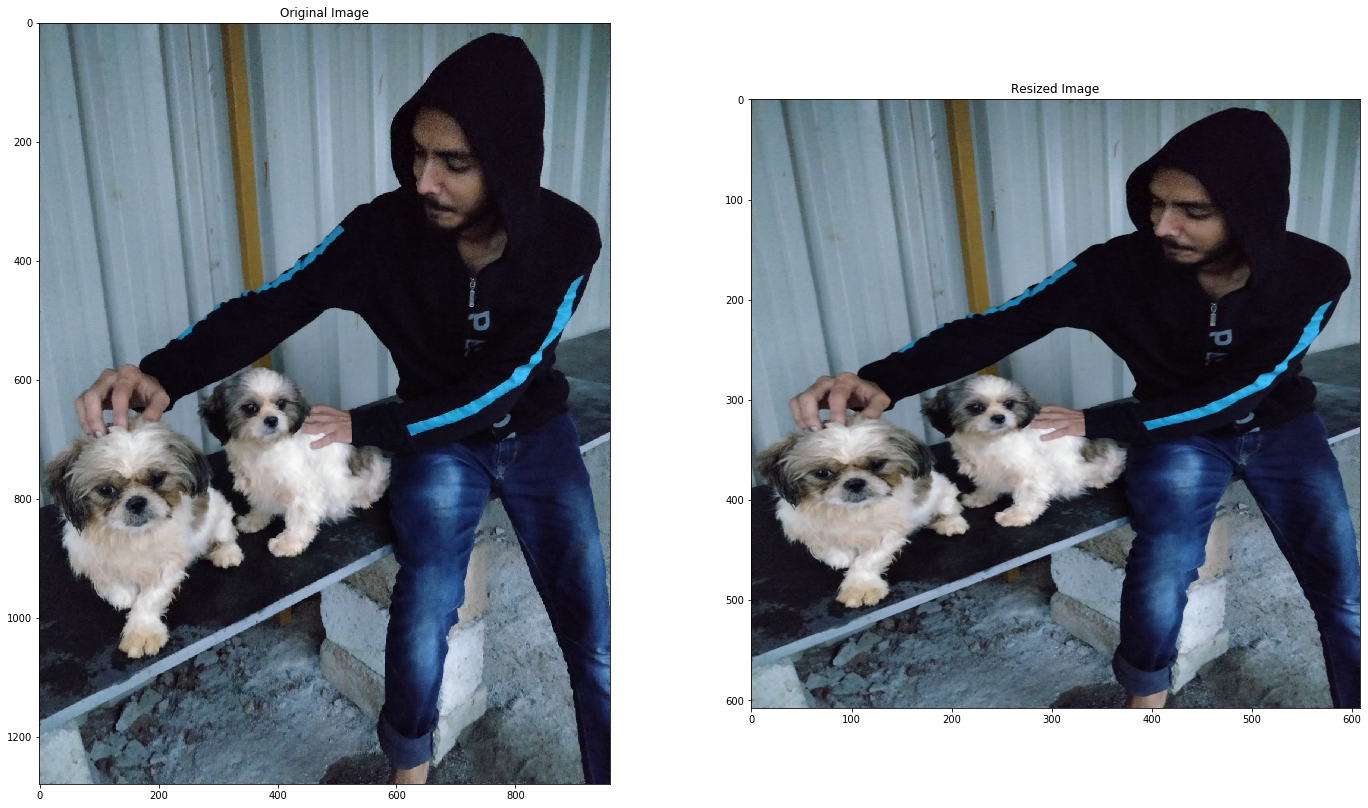

In [5]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('/Users/mayurjain/Desktop/cv_images/yolo_mod.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

In [6]:
nms_thresh = 0.6
iou_thresh = 0.4



It took 3.789 seconds to detect the objects in the image.

Number of Objects Detected: 3 

Objects Found and Confidence Level:

1. person: 0.999996
2. dog: 0.999999
3. dog: 1.000000


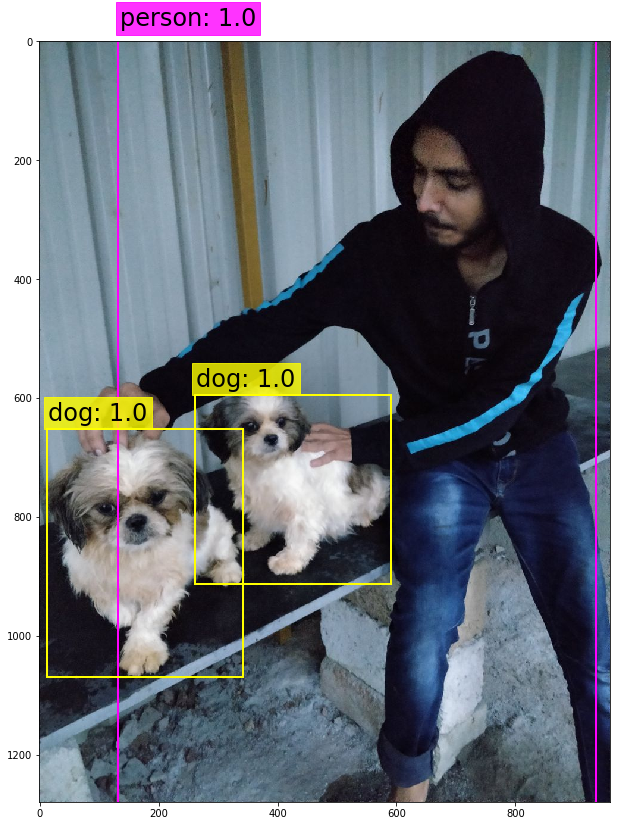

In [7]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('/Users/mayurjain/Desktop/cv_images/yolo_mod.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)

In [42]:
gif = cv2.VideoCapture(gif_slingshot)
colors = np.random.uniform(0,255,size=(len(class_names),3))
font = cv2.FONT_HERSHEY_PLAIN
img_array = []

while not gif.isOpened():
    gif = cv2.VideoCapture(gif_slingshot)
    cv2.waitKey(1000)
    print("Wait for the header")
    
pos_frame = gif.get(cv2.CAP_PROP_POS_FRAMES)

while True:
    rval, frame = gif.read()
    
    if rval:
        original_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(original_image, (m.height, m.width))
        iou_thresh = 0.2
        nms_thresh = 0.3
        boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)
        
        width = frame.shape[1]
        height = frame.shape[0]

        for i in range(len(boxes)):
            box = boxes[i]
        
            # Get the (x,y) pixel coordinates of the lower-left and lower-right corners
            # of the bounding box relative to the size of the image. 
            x1 = int(np.around((box[0] - box[2]/2.0) * width))
            y1 = int(np.around((box[1] - box[3]/2.0) * height))
            x2 = int(np.around((box[0] + box[2]/2.0) * width))
            y2 = int(np.around((box[1] + box[3]/2.0) * height))
            
            width_x = x2 - x1
            width_y = y1 - y2
            
            #print(boxes[i][0],boxes[i][1],boxes[i][2],boxes[i][3])
            #x,y,w,h = boxes[i][0],boxes[i][1],boxes[i][2],boxes[i][3]
            x,y,w,h = x1, y2, width_x, width_y
            color = colors[boxes[i][6]]
            cv2.rectangle(frame,(x, y),(x+w, y+h),color,2)
            cv2.putText(frame,class_names[boxes[i][6]]+" "+str(np.around(boxes[i][5],2)),(x,y),font,1,(255,255,255),2)
        cv2.imshow("image",frame)
        img_array.append(frame)
        key = cv2.waitKey(1)

    else:
        # The next frame is not ready, so we try to read it again
        gif.set(cv2.CAP_PROP_POS_FRAMES, pos_frame-1)
        print("frame is not ready")
        # It is better to wait for a while for the next frame to be ready
        cv2.waitKey(1000)
        
    if key ==27:
        break

    if gif.get(cv2.CAP_PROP_POS_FRAMES) == gif.get(cv2.CAP_PROP_FRAME_COUNT):
        break
        
gif.release()
cv2.destroyAllWindows()




It took 3.424 seconds to detect the objects in the image.

Number of Objects Detected: 3 



It took 3.395 seconds to detect the objects in the image.

Number of Objects Detected: 5 



It took 3.349 seconds to detect the objects in the image.

Number of Objects Detected: 5 



It took 3.300 seconds to detect the objects in the image.

Number of Objects Detected: 3 



It took 3.397 seconds to detect the objects in the image.

Number of Objects Detected: 4 



It took 4.129 seconds to detect the objects in the image.

Number of Objects Detected: 4 



It took 3.782 seconds to detect the objects in the image.

Number of Objects Detected: 3 



It took 3.291 seconds to detect the objects in the image.

Number of Objects Detected: 4 



It took 3.347 seconds to detect the objects in the image.

Number of Objects Detected: 3 



It took 4.424 seconds to detect the objects in the image.

Number of Objects Detected: 4 



It took 3.321 seconds to detect the objects in the image.

Number of



It took 3.353 seconds to detect the objects in the image.

Number of Objects Detected: 0 



In [47]:
size = (width,height)
out = cv2.VideoWriter("/Users/mayurjain/Desktop/cv_images/obj_det.mp4",cv2.VideoWriter_fourcc(*'DIVX'), 3.4, size)
 
for i in range(len(img_array)):
    # writing to a image array
    out.write(img_array[i])
out.release()